In [1]:
# we will be using the following libraries
%matplotlib notebook
import networkx as nx
import numpy as np

# Network definition
The first step is to define the network as a `nx.Digraph` object. Positions (coordinates) are not mandatory but allow displaying the graph properly.

<IPython.core.display.Javascript object>


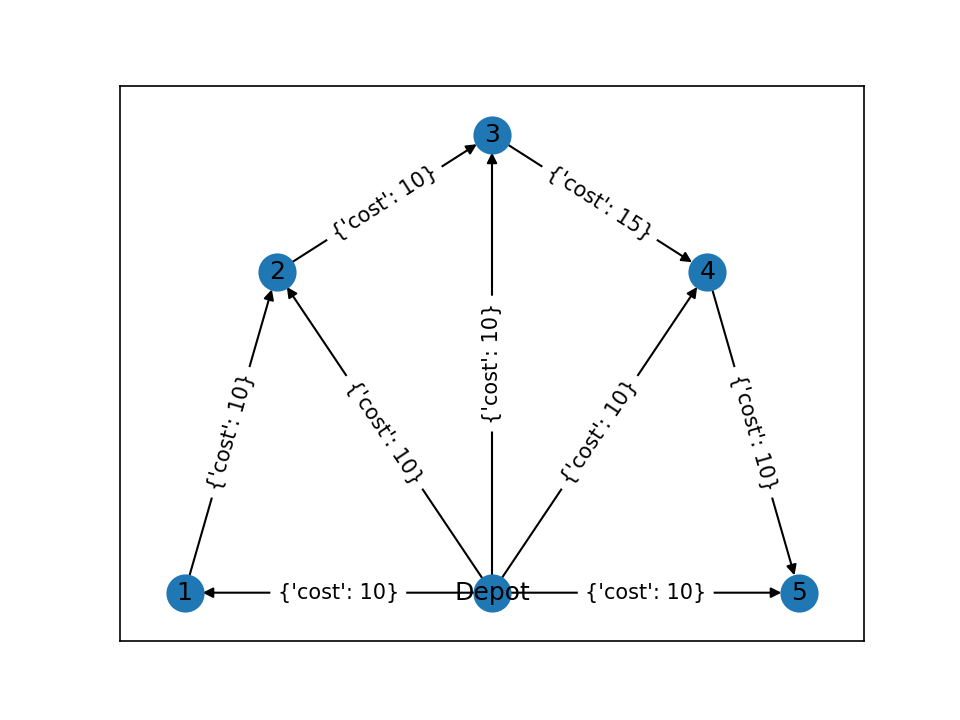

{('Depot', 1): Text(-0.5, 0.0, "{'cost': 10}"),
 ('Depot', 2): Text(-0.35, 0.35, "{'cost': 10}"),
 ('Depot', 3): Text(0.0, 0.5, "{'cost': 10}"),
 ('Depot', 4): Text(0.35, 0.35, "{'cost': 10}"),
 ('Depot', 5): Text(0.5, 0.0, "{'cost': 10}"),
 (1, 2): Text(-0.85, 0.35, "{'cost': 10}"),
 (2, 3): Text(-0.35, 0.85, "{'cost': 10}"),
 (3, 4): Text(0.35, 0.85, "{'cost': 15}"),
 (4, 5): Text(0.85, 0.35, "{'cost': 10}")}

In [3]:
coordinates = {1:(-1,0),2:(-0.7,0.7),3:(0,1),4:(0.7,0.7),5:(1,0)}

# Create graph
G = nx.DiGraph()

# Add nodes
G.add_node("Depot",x=0,y=0)
for v in coordinates:
    G.add_node(v,x=coordinates[v][0],y=coordinates[v][1])
    
# Add edges
for v in G.nodes():
    if v !="Depot":
        G.add_edge("Depot", v, cost=10)
G.add_edge(1, 2, cost=10)
G.add_edge(2, 3, cost=10)
G.add_edge(3, 4, cost=15)
G.add_edge(4, 5, cost=10)

# Draw network
pos = {}
for v in G.nodes():
    pos[v] = np.array([G.nodes[v]["x"], G.nodes[v]["y"]])    
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos)

# VRP definition

In [4]:
import sys
sys.path.append("../")
from vrpy.main import VehicleRoutingProblem

The second step is to define the VRP, with the previously defined graph as an input. Also, for convenience, the depot is split into two vertices : the `Source` and the `Sink`.

In [5]:
G = nx.relabel_nodes(G,{"Depot":"Source"})
for v in coordinates:
    if v!="Source":
        G.add_edge(v,"Sink",cost=G.edges["Source",v]["cost"])
        
prob = VehicleRoutingProblem(G)

# Maximum number of stops per route

In this first variant, it is required that a vehicle cannot perform more than 3 stops.

In [6]:
prob.num_stops=3
prob.solve()

The best routes found can be accessed as follows:

In [7]:
prob.best_routes

[['Source', 1, 2, 3, 'Sink'], ['Source', 4, 5, 'Sink']]

And the value of the solution is:

In [8]:
prob.best_value

70.0

<IPython.core.display.Javascript object>


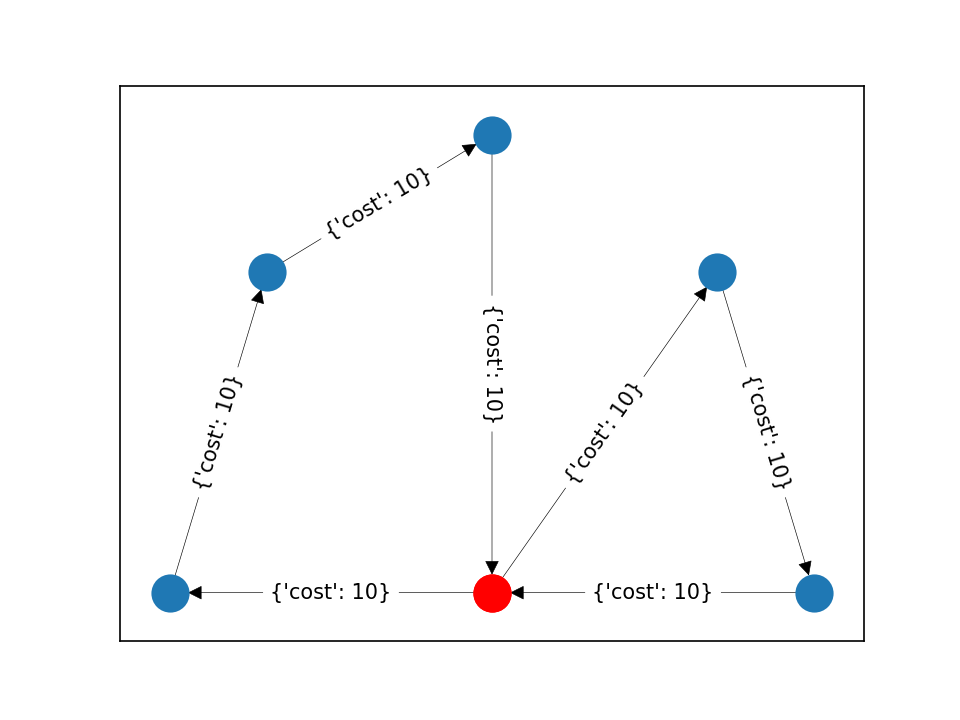

In [10]:
pos["Source"] = np.array([0,0])
pos["Sink"] = np.array([0,0])
nx.draw_networkx_nodes(G,pos, nodelist=[1,2,3,4,5])
nx.draw_networkx_nodes(G, pos, nodelist=["Source", "Sink"], node_color="r")
options = {"arrowsize":15,"line_color": "grey","width": 0.3}
for route in prob.best_routes_as_graphs:
    nx.draw_networkx_edges(route, pos, **options)
    nx.draw_networkx_edge_labels(route,pos)

# Capacity constraints

In this second variant, we define a demand $d_v$ for each customer $v\in V$, and limit the vehicle capacity to 10 units, that is :
$$
\sum_{v\in V} d_v \le 10.
$$

In [11]:
for v in G.nodes():
    if v not in ["Source","Sink"]:
        G.nodes[v]["demand"] = 5

The capacity constraint is set with the `load_capacity` attribute.

In [12]:
prob.load_capacity = 10
prob.solve()
prob.best_value

80.0

As the problem is more constrained, it is not surprising that the total cost increases.

<IPython.core.display.Javascript object>


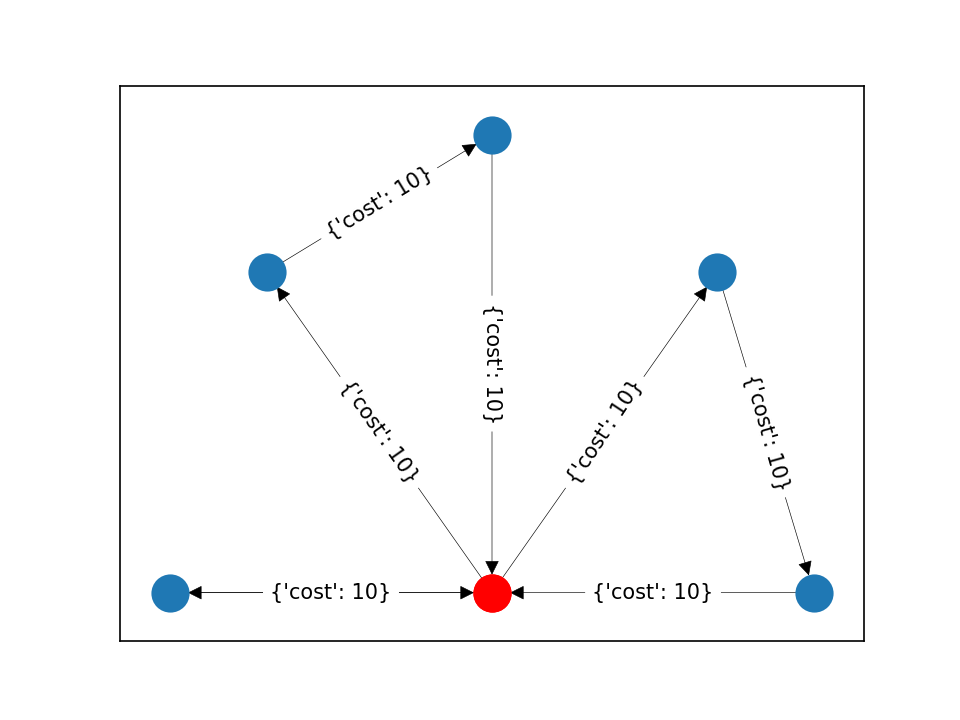

In [13]:
nx.draw_networkx_nodes(G,pos, nodelist=[1,2,3,4,5])
nx.draw_networkx_nodes(G, pos, nodelist=["Source", "Sink"], node_color="r")
for route in prob.best_routes_as_graphs:
    nx.draw_networkx_edges(route, pos, **options)
    nx.draw_networkx_edge_labels(route,pos)

# Time constraints

One may want to restrict total duration of a route. In this cas, a time attribute $\Delta t_{ij}$ is added to each edge $(i,j) \in E$, and a maximum duration is set. In this example, it is set to 60, such that the following inequality holds for each route :
$$
\sum_{(i,j)\in E} \Delta t_{ij} \le 60.
$$

In [14]:
for (u,v) in G.edges():
    G.edges[u,v]["time"] = 20
G.edges[4,5]["time"] = 25

prob.duration = 60
prob.solve()
prob.best_value

85.0

Again, the total cost continues to increase.

<IPython.core.display.Javascript object>


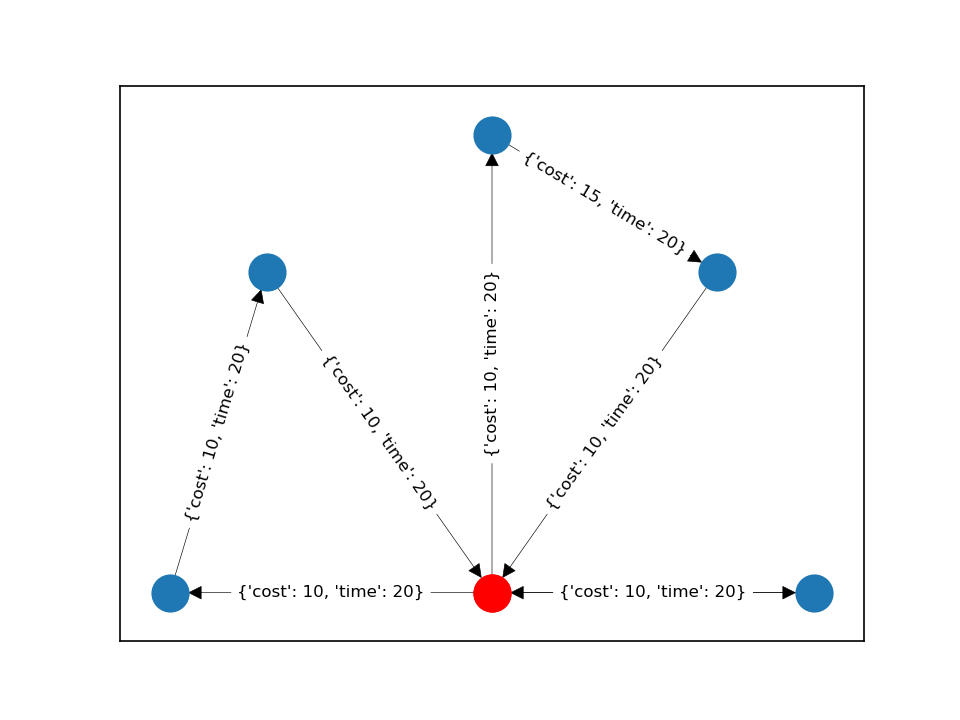

In [15]:
nx.draw_networkx_nodes(G,pos, nodelist=[1,2,3,4,5])
nx.draw_networkx_nodes(G, pos, nodelist=["Source", "Sink"], node_color="r")
for route in prob.best_routes_as_graphs:
    for (i,j) in route.edges():
        route.edges[i,j]["time"] = G.edges[i,j]["time"]
    nx.draw_networkx_edges(route, pos, **options)
    nx.draw_networkx_edge_labels(route,pos,font_size=8)

# Time windows constraints

When designing routes, it may be required that a customer is serviced in a given time window $[\ell,u]$. Such time windows are defined for each node, as well as service times.

In [16]:
time_windows = {"Source":(0,100),"Sink":(0,110),1:(5,100),2:(5,20),3:(5,100),4:(5,100),5:(5,100)}
for v in G.nodes():
    G.nodes[v]["lower"] = time_windows[v][0]
    G.nodes[v]["upper"] = time_windows[v][1]
    if v not in ["Source","Sink"]:
        G.nodes[v]["service_time"] = 1

A boolean parameter `time_windows` is given as an input to enforce such constraints.

In [17]:
prob.time_windows = True 
prob.duration = 64
prob.solve(cspy=False)
prob.best_value

90.0

<IPython.core.display.Javascript object>


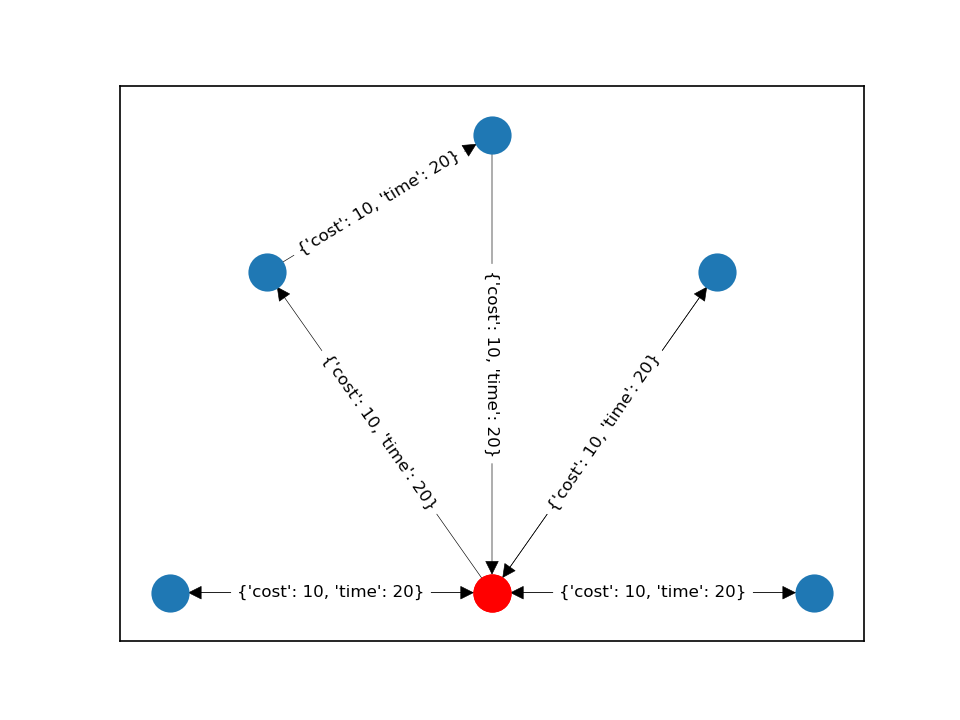

In [18]:
nx.draw_networkx_nodes(G,pos, nodelist=[1,2,3,4,5])
nx.draw_networkx_nodes(G, pos, nodelist=["Source", "Sink"], node_color="r")
for route in prob.best_routes_as_graphs:
    for (i,j) in route.edges():
        route.edges[i,j]["time"] = G.edges[i,j]["time"]
    nx.draw_networkx_edges(route, pos, **options)
    nx.draw_networkx_edge_labels(route,pos,font_size=8)